
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Monthly Mean Sea Level using a non-linear regression model and AWTs PCs

inputs required: 
  * WaterLevel historical data from a tide gauge at the study site 
  * SST AWTs historical and simulated PCs

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
from collections import OrderedDict

# python libs
import numpy as np
import xarray as xr
from scipy.stats import linregress
from scipy.optimize import least_squares
from datetime import datetime, timedelta

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.tides import Calculate_MMSL
from teslakit.statistical import runmean
from teslakit.util.time_operations import date2yearfrac as d2yf

from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL, \
Plot_Validate_MMSL_tseries, Plot_Validate_MMSL_scatter, Plot_MMSL_Prediction, \
Plot_MMSL_Histogram



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

TIDE_gauge, _ = db.Load_TIDE_hist()      # water level historical data (tide gauge)
TIDE = TIDE_gauge.WaterLevel

SST_KMA = db.Load_SST_KMA()              # SST Anual Weather Types PCs
SST_PCs_sim_m = db.Load_SST_PCs_sim_m()  # simulated SST PCs (monthly)

# parameters for mmsl calculation
mmsl_year_ini = 1996
mmsl_year_end = 2017



## Monthly Mean Sea Level

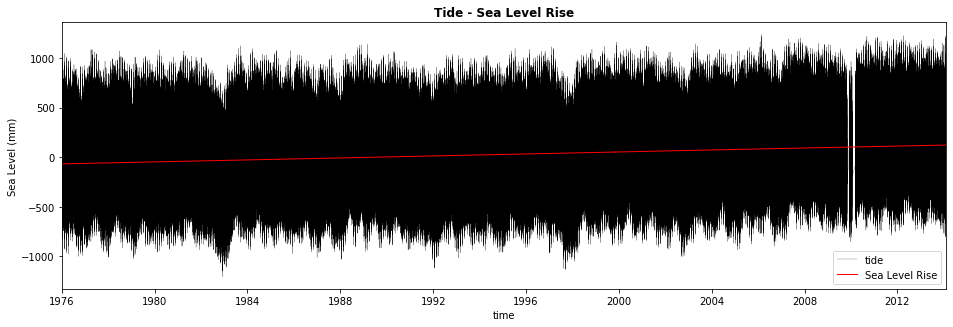

In [4]:
# --------------------------------------
# Calculate SLR using linear regression

time = TIDE.time.values[:]
tide = TIDE.values[:] * 1000  # (m to mm)

lr_time = np.array(range(len(time)))  # for linregress
slope, intercept, r_value, p_value, std_err = linregress(lr_time, tide)
slr = intercept + slope * lr_time

# Plot tide with SLR
Plot_Tide_SLR(time, tide, slr);


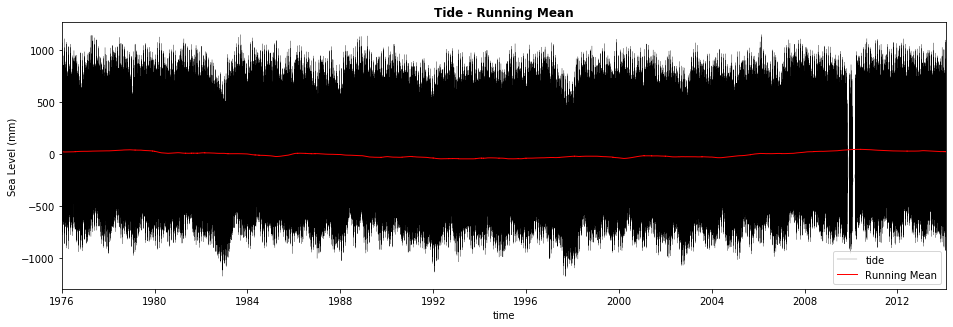

In [5]:
# --------------------------------------
# remove SLR and runmean from tide 

tide_noslr = tide - slr

# calculate tide running mean
time_window = 365*24*3
runm = runmean(tide_noslr, time_window, 'mean')

# remove running mean
tide_noslr_norunm = tide_noslr - runm

# store data 
TNSR = xr.DataArray(tide_noslr_norunm,  dims=('time'), coords={'time':time})


# Plot tide without SLR and runm
Plot_Tide_RUNM(time, tide_noslr, runm);


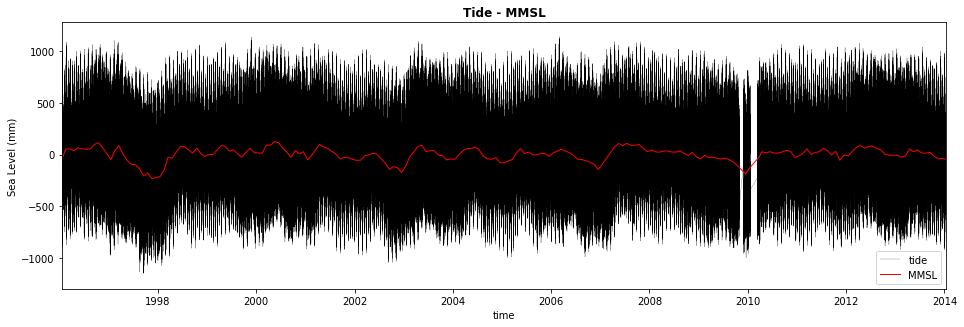

In [6]:
# --------------------------------------
# calculate Monthly Mean Sea Level (mmsl)

MMSL = Calculate_MMSL(TNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(TNSR.time, TNSR.values, mmsl_time, mmsl_vals);

# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)



## Monthly Mean Sea Level - Principal Components

In [7]:
# --------------------------------------
# SST Anual Weather Types PCs

PCs = np.array(SST_KMA.PCs.values)
PC1, PC2, PC3 = PCs[:,0], PCs[:,1], PCs[:,2]
PCs_years = [int(str(t).split('-')[0]) for t in SST_KMA.time.values[:]]

# MMSL PCs calculations: cut and pad it to monthly resolution
ntrs_m_mean = np.array([])
ntrs_time = []

MMSL_PC1 = np.array([])
MMSL_PC2 = np.array([])
MMSL_PC3 = np.array([])

for c, y in enumerate(PCs_years):
    pos = np.where(
        (mmsl_time >= np.datetime64('{0}-06-01'.format(y))) &
        (mmsl_time <= np.datetime64('{0}-05-29'.format(y+1)))
    )

    if pos[0].size:
        ntrs_m_mean = np.concatenate((ntrs_m_mean, mmsl_vals[pos]),axis=0)
        # TODO check for 0s and nans in ntrs_m_mean?
        ntrs_time.append(mmsl_time[pos])

        MMSL_PC1 = np.concatenate((MMSL_PC1, np.ones(pos[0].size)*PC1[c]),axis=0)
        MMSL_PC2= np.concatenate((MMSL_PC2, np.ones(pos[0].size)*PC2[c]),axis=0)
        MMSL_PC3 = np.concatenate((MMSL_PC3, np.ones(pos[0].size)*PC3[c]),axis=0)

ntrs_time = np.concatenate(ntrs_time)


# Parse time to year fraction for non-linear-model seasonality 
frac_year = np.array([d2yf(x) for x in ntrs_time])



## Monthly Mean Sea Level - Non Linear Regression Model

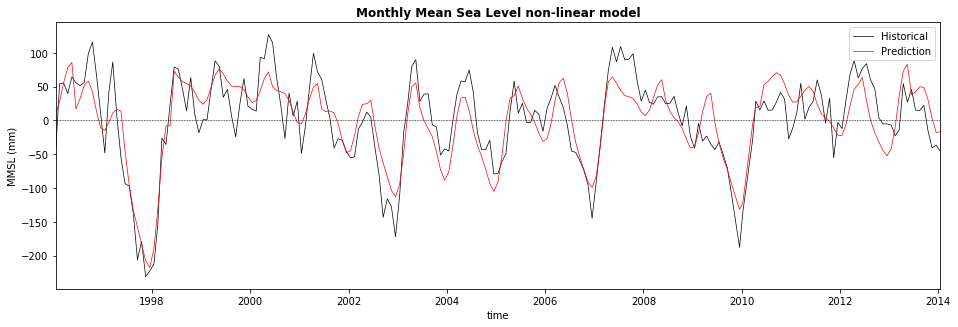

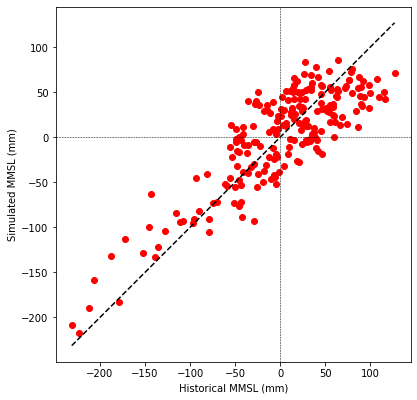

In [8]:
# --------------------------------------
# Fit non linear regression model

def modelfun(x, t, pc1, pc2, pc3, y):
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            np.array([x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3]).flatten() * np.cos(2*np.pi*t) + \
            np.array([x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3]).flatten() * np.sin(2*np.pi*t) + \
            np.array([x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3]).flatten() * np.cos(4*np.pi*t) + \
            np.array([x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3]).flatten() * np.sin(4*np.pi*t) - y

x0 = np.ones(20)
res_lsq = least_squares(
    modelfun, x0,
    args = (frac_year, MMSL_PC1, MMSL_PC2, MMSL_PC3, ntrs_m_mean)
)


# check model at fitting period
y_0s = np.zeros(frac_year.shape)
y_p = modelfun(res_lsq.x, frac_year, MMSL_PC1, MMSL_PC2, MMSL_PC3, y_0s)

Plot_Validate_MMSL_tseries(ntrs_time, ntrs_m_mean, y_p);

Plot_Validate_MMSL_scatter(ntrs_m_mean, y_p);


# Save model parameters
model_coefs = xr.Dataset(
    {
        'sim_params' : (('n_params'), res_lsq.x),
    },
)
model_coefs.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/ROI/TIDE/tide_mmsl_sim_params.nc')



## Monthly Mean Sea Level - Prediction

In [9]:
# --------------------------------------
# Predict 1000 years using simulated PCs (monthly time resolution)

# get simulation time as year fractions
PCs_sim_time = SST_PCs_sim_m.time.values[:]
frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])

# solve each PCs simulation
l_MMSL_sim = []
for s in SST_PCs_sim_m.n_sim:
    
    PCs_s_m = SST_PCs_sim_m.sel(n_sim=s)
    MMSL_PC1_sim = PCs_s_m.PC1.values[:]
    MMSL_PC2_sim = PCs_s_m.PC2.values[:]
    MMSL_PC3_sim = PCs_s_m.PC3.values[:]

    # use non-linear-model
    y_0s = np.zeros(frac_year_sim.shape)
    y_sim = modelfun(res_lsq.x, frac_year_sim, MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim, y_0s)

    # append simulated MMSL
    l_MMSL_sim.append(
        xr.Dataset(
            {
                'mmsl' : (('time',), y_sim / 1000),  # mm to m
            },
            {'time' : PCs_sim_time}
        )
    )
    
# concatenate simulations
MMSL_sim = xr.concat(l_MMSL_sim, 'n_sim')
print(MMSL_sim)

db.Save_TIDE_sim_mmsl(MMSL_sim)


<xarray.Dataset>
Dimensions:  (n_sim: 1, time: 12012)
Coordinates:
  * time     (time) object 1699-06-01 00:00:00 ... 2700-05-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    mmsl     (n_sim, time) float64 0.06581 0.02949 -0.0125 ... 0.003829 0.004923



MMSL Simulation 0


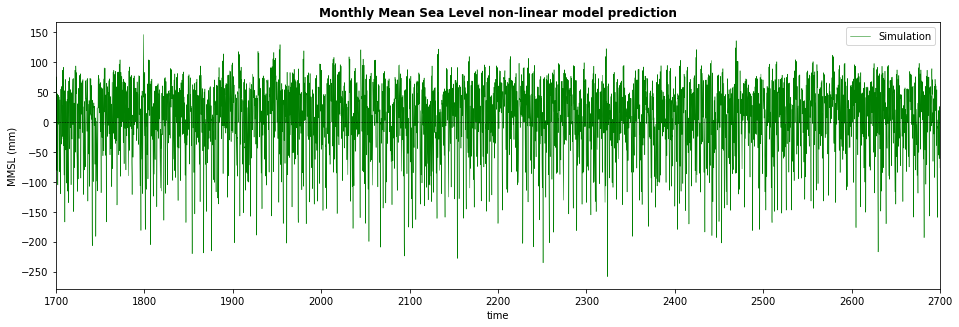

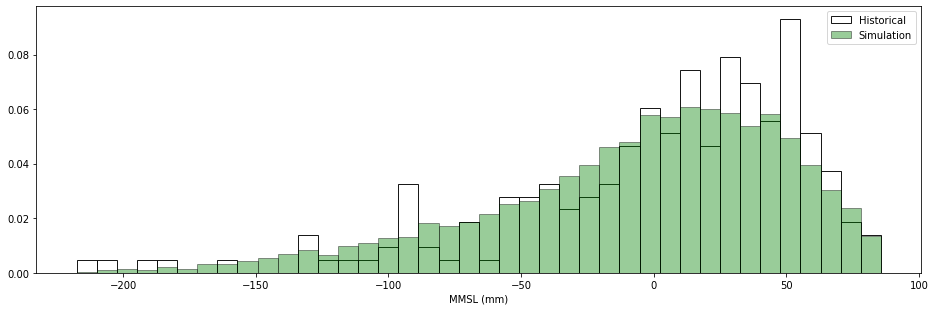

In [10]:
# Plot each simulation prediction

for s in MMSL_sim.n_sim: 
    print('\nMMSL Simulation {0}'.format(s.values))

    y_sim = MMSL_sim.sel(n_sim=s).mmsl.values[:] * 1000  # m to mm
    t_sim = MMSL_sim.sel(n_sim=s).time.values[:]

    # Plot mmsl prediction
    Plot_MMSL_Prediction(t_sim, y_sim);

    # compare model histograms
    Plot_MMSL_Histogram(y_p, y_sim);
